In [3]:
import anndata as ad
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD

In [4]:
import plotly.express as px

In [5]:
dataset_path = '../output/datasets/joint_embedding/openproblems_bmmc_multiome_phase1/openproblems_bmmc_multiome_phase1.censor_dataset.output_'
solution_path = dataset_path + "solution.h5ad"

In [6]:
n_dim = 100
ad_mod1 = ad.read_h5ad(dataset_path + 'mod1.h5ad')
ad_mod2 = ad.read_h5ad(dataset_path + 'mod2.h5ad')

In [7]:
adata_solution = ad.read_h5ad(solution_path)
ad_mod1.obs['cell_type'] = adata_solution.obs['cell_type'][ad_mod1.obs_names]
ad_mod2.obs['cell_type'] = adata_solution.obs['cell_type'][ad_mod2.obs_names]

In [8]:
gex_dense = ad_mod1.X.todense()

In [9]:
gex_dense.shape

(22463, 13431)

![image.png](gex_umap.png)

In [10]:
atac_dense = ad_mod2.X.todense()

In [11]:
atac_dense.shape

(22463, 116490)

![image.png](atac_umap.png)

GEX over genes, ATAC over the entire genome

ATAC is either 1 or 0, since it was binarized

In [32]:
accessible_region_cells = atac_dense.sum(axis=0)

In [36]:
pd.DataFrame(accessible_region_cells / atac_dense.shape[0]).T.describe()

0
count  116490.000000
mean        0.026820
std         0.050227
min         0.001157
25%         0.004941
50%         0.008859
75%         0.020478
max         0.509193

The fraction of cells for which a given region is accessible is tiny, ~1%

In [37]:
genes_description = pd.DataFrame(gex_dense).describe()

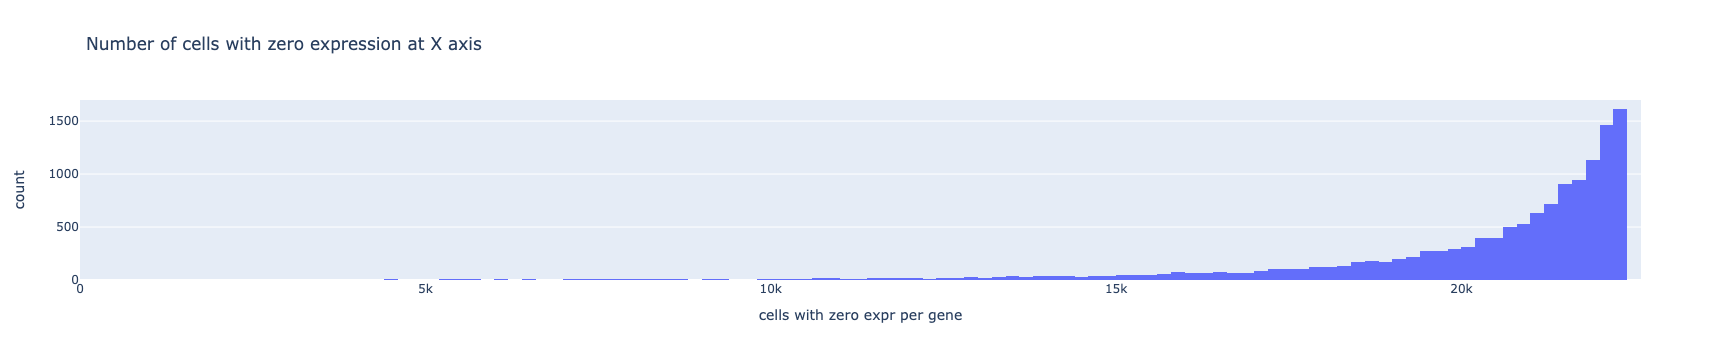

In [49]:
px.histogram(pd.DataFrame((gex_dense == 0).sum(0)).T.rename(columns={0:"cells with zero expr per gene"}), "cells with zero expr per gene", title="Number of cells with zero expression at X axis")

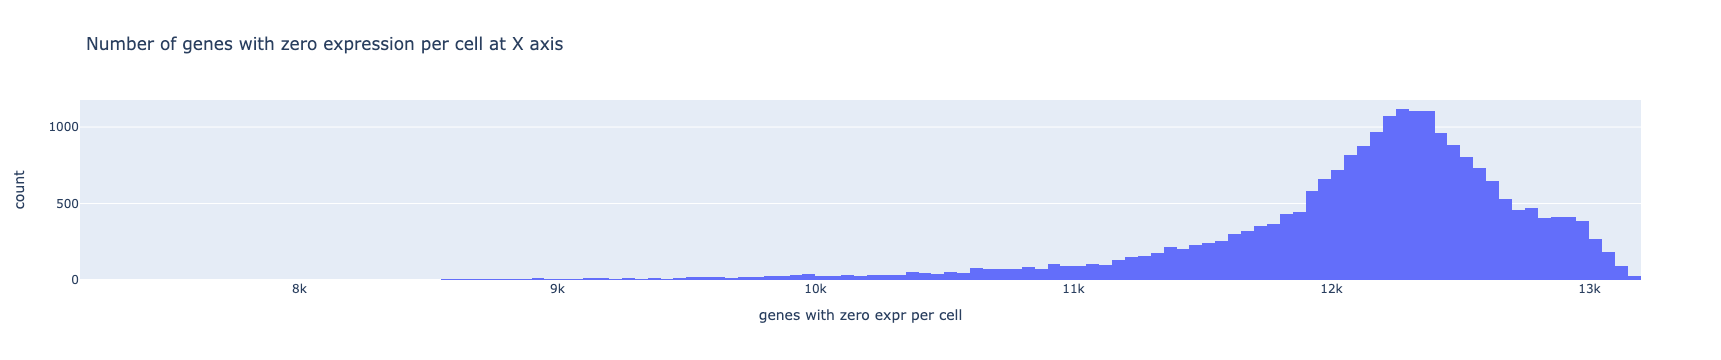

In [51]:
px.histogram(pd.DataFrame((gex_dense == 0).sum(1)).rename(columns={0:"genes with zero expr per cell"}), "genes with zero expr per cell", title="Number of genes with zero expression per cell at X axis")

### count_per_region = atac_dense.sum(axis=0)

In [22]:
count_per_region = count_per_region.astype(int).reshape(-1)

In [23]:
count_per_region = pd.DataFrame(count_per_region).T

In [24]:
count_per_region.rename(columns={0:"Cells with region accessible"}, inplace=True)

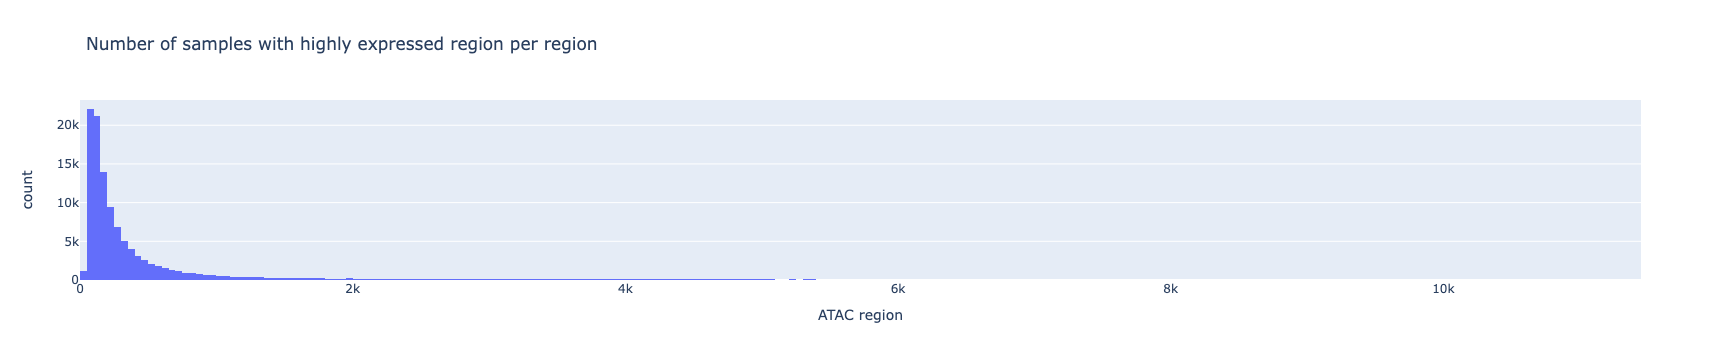

In [25]:
px.histogram(count_per_region, x="Cells with region accessible", title="Number of cells with a region accessible")

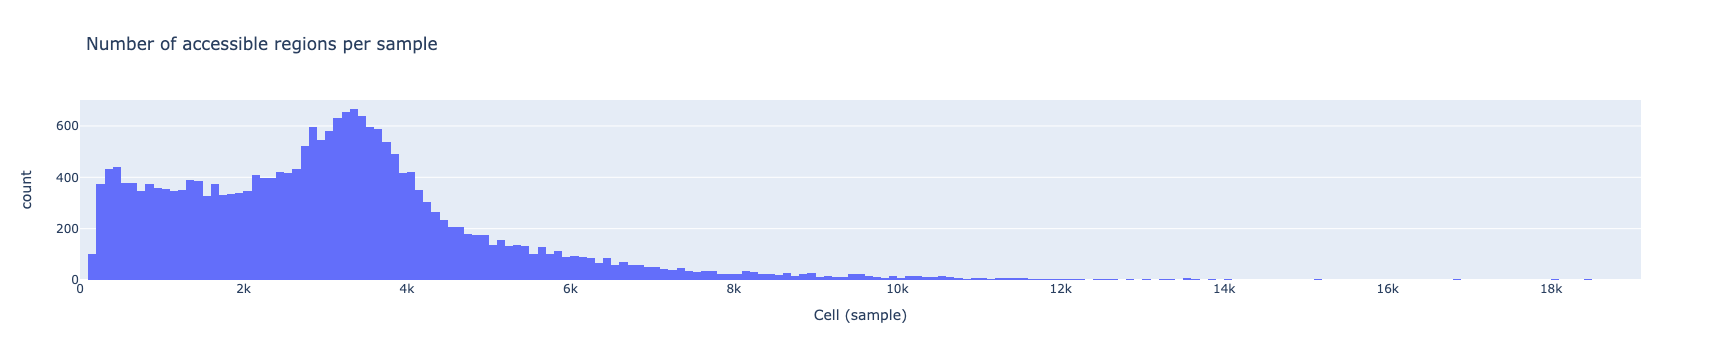

In [26]:
count_per_region = atac_dense.sum(axis=1)
count_per_region = count_per_region.astype(int).reshape(-1)
count_per_region = pd.DataFrame(count_per_region).T
count_per_region.rename(columns={0:"Accessible regions per sample"}, inplace=True)
px.histogram(count_per_region, x="Accessible regions per sample", title="Number of accessible regions per sample")

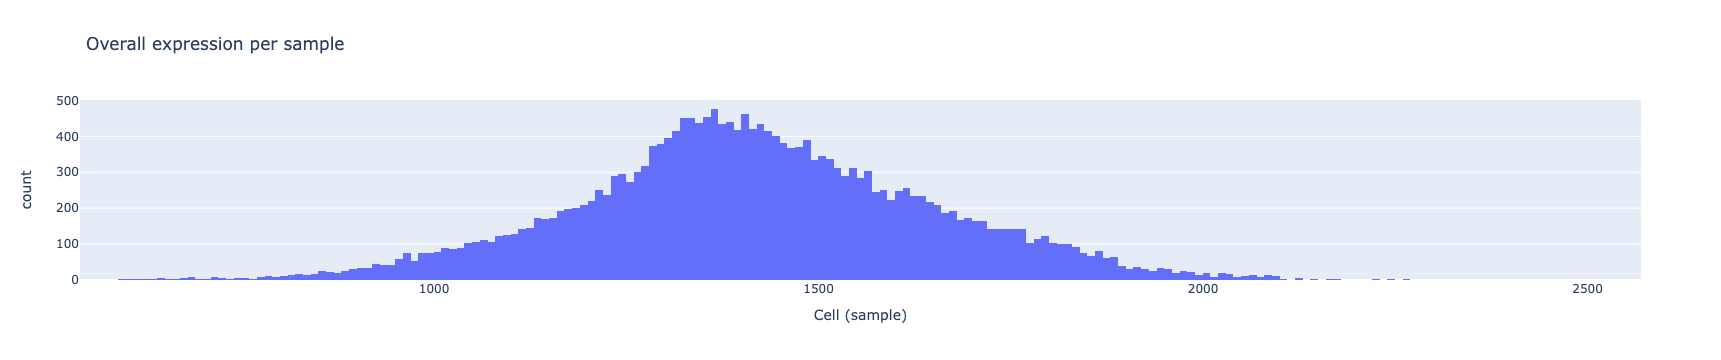

In [27]:
count_per_region = gex_dense.sum(axis=1)
count_per_region = count_per_region.astype(int).reshape(-1)
count_per_region = pd.DataFrame(count_per_region).T
count_per_region.rename(columns={0:"Overall expression per cell"}, inplace=True)
px.histogram(count_per_region, x="Overall expression per cell", title="Overall expression per sample")

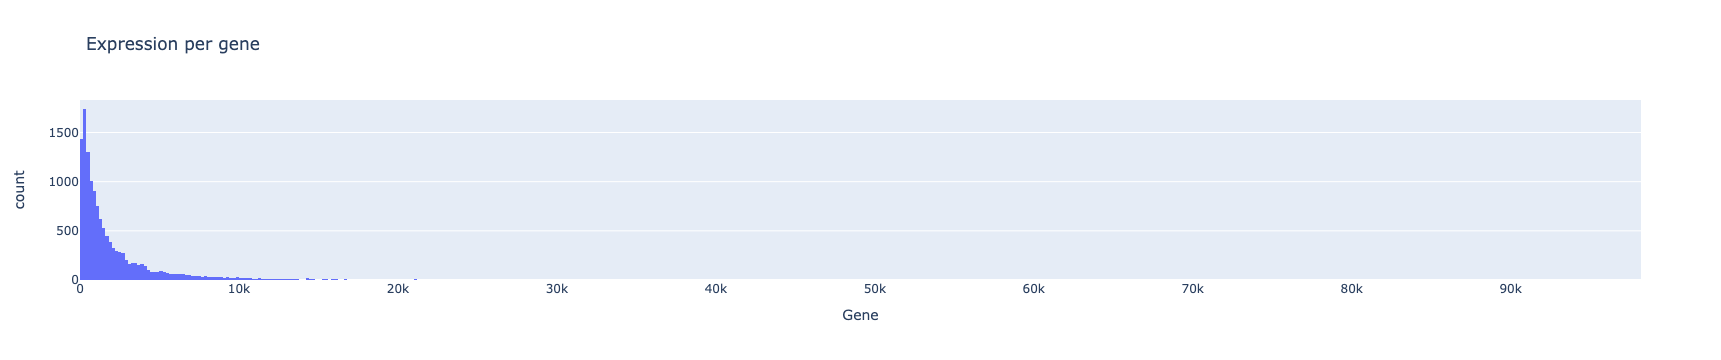

In [28]:
count_per_region = gex_dense.sum(axis=0)
count_per_region = count_per_region.astype(int).reshape(-1)
count_per_region = pd.DataFrame(count_per_region).T
count_per_region.rename(columns={0:"Overall expression per gene"}, inplace=True)
px.histogram(count_per_region, x="Overall expression per gene", title="Expression per gene")

In [4]:
# TODO: implement your own method
embedder_mod1 = TruncatedSVD(n_components=n_dim//2)
mod1_pca = embedder_mod1.fit_transform(ad_mod1.X)
mod1_obs = ad_mod1.obs
mod1_uns = ad_mod1.uns
del ad_mod1

# 'Performing dimensionality reduction on modality 2 values...'
embedder_mod1 = TruncatedSVD(n_components=n_dim//2)
mod2_pca = embedder_mod1.fit_transform(ad_mod2.X)
del ad_mod2

# 'Concatenating datasets'
pca_combined = np.concatenate([mod1_pca, mod2_pca], axis=1)

# put into anndata
adata = ad.AnnData(
    X=pca_combined,
    obs=mod1_obs,
    uns={
        'dataset_id': mod1_uns['dataset_id']
    },
)
# Transfer obs annotations
adata.obs['batch'] = adata_solution.obs['batch'][adata.obs_names]
adata.obs['cell_type'] = adata_solution.obs['cell_type'][adata.obs_names]

# Preprocessing
adata.obsm['X_emb'] = adata.X